# Mullti-task Learning on Cifar10 Dataset: A CNN Approach
- Name: Minh T. Nguyen
- ECE 6524 - Final Project
- Date: 4/14/2023
- **Objective**: Build a MTL model for image classification.
    - Task 1: Multi-class classification (airplane, automobile, bird, cat, dog, frog, ship, truck).
    - Task 2: Super-class binary classification (animal, vehicle)
- **To Do**:
    - Try with balance and imbalanced classes.
    - Experience with Transfer Learning.
    - Experience with Different Architecture.
    - Experience with Different Model Configuration: 
        - Optimizers.
        - Regularization: Data Augmentation, Batch Normalization, L1/L2/Combined Regularization, Dropout, Early Stopping.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import np_utils, plot_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras import Model

In [2]:
tf.version.VERSION

'2.11.0'

# 1. Data Visualization & Preprocessing

In [3]:
# download data from Keras API
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
# check dataset size
print(f"X={X_train.shape}, y={y_train.shape}")
print(f"X={X_test.shape}, y={y_test.shape}")

X=(50000, 32, 32, 3), y=(50000, 1)
X=(10000, 32, 32, 3), y=(10000, 1)


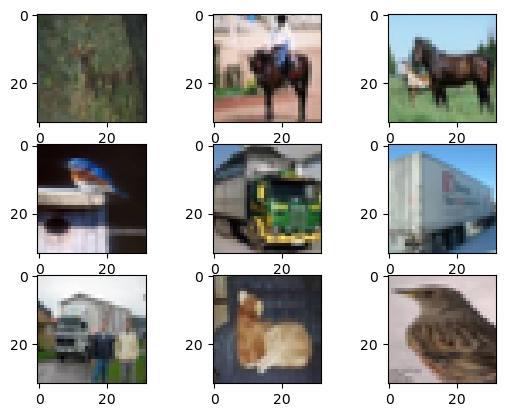

In [5]:
# plot the 9 images
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(X_train[10])
axarr[0,1].imshow(X_train[11])
axarr[0,2].imshow(X_train[12])
axarr[1,0].imshow(X_train[13])
axarr[1,1].imshow(X_train[14])
axarr[1,2].imshow(X_train[15])
axarr[2,0].imshow(X_train[16])
axarr[2,1].imshow(X_train[17])
axarr[2,2].imshow(X_train[18])
plt.show()

## 1.2. Class Balancing
The super-classes are divided into animals and vehicles:
- **Animals**: Bird, Cat, Deer, Dog, Frog, Horse. (5000x6 training images, 1000x6 testing images).
- **Vehicles**: Airplane, Automotive, Ship, Truck. (5000x4 training images, 1000x4 testing images).

To make the super-class balance, we will get rid of Deer and Horse.

From [Cifar 10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html), we know that the labels have the corresponding label number:
- Airplane: 0.
- Automobile: 1.
- Bird: 2.
- Cat: 3.
- Deer: 4.
- Dog: 5.
- Frog: 6.
- Horse: 7.
- Ship: 8.
- Truck 9.

In [6]:
def balanced_classes(classes_to_drop, X_train, X_test, y_train, y_test):
    """
    Generates a balanced class by dropping Deer and Horse class
    @Parameters:
    - classes_to_drop: list of index of classes to drop.
    - X_train: list of training images.
    - X_test: list of testing images.
    - y_train: list of training labels.
    - y_test: list of testing labels.
    
    @Return:
    - X_train: list of balanced training images.
    - X_test: list of balanced testing images.
    - y_train: list of balanced training labels.
    - y_test: list of balanced testing labels.
    """
    # create empty lists for class-balancing
    new_X_train, new_X_test, new_y_train, new_y_test = list(), list(), list(), list()
    
    # append any classs that is not Deer or Horse in the training set
    for train_image, train_label in zip(X_train, y_train):
        if train_label not in classes_to_drop:
            new_X_train.append(train_image)
            new_y_train.append(train_label)
            
    # append any classes that is not Deer or Horse in the testing set
    for test_image, test_label in zip(X_test, y_test):
        if test_label not in classes_to_drop:
            new_X_test.append(test_image)
            new_y_test.append(test_label)
    
    return np.array(new_X_train), np.array(new_y_train), np.array(new_X_test), np.array(new_y_test)

In [7]:
# get the balance-class dataset
new_X_train, new_y_train8, new_X_test, new_y_test8 = balanced_classes(
    classes_to_drop=[4,7],
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

**Note**: We expect that to have 5000x8 number of training samples and 1000x8 number of testing samples.

In [8]:
# check shape
print(f"The new training dataset has the shape of {new_X_train.shape}")
print(f"The new training dataset has the shape of {new_y_train8.shape}")
print(f"The new testing dataset has the shape of {new_X_test.shape}")
print(f"The new testing dataset has the shape of {new_y_test8.shape}")

The new training dataset has the shape of (40000, 32, 32, 3)
The new training dataset has the shape of (40000, 1)
The new testing dataset has the shape of (8000, 32, 32, 3)
The new testing dataset has the shape of (8000, 1)


**Note**: Since we remove the number values of 4, 7 for Deer and Horse, we will need to make sure to reorder the label to make it into categorical label later.

In [9]:
# reorder training label
new_y_train = list()

for train_label in new_y_train8:
    if train_label == 5:
        new_y_train.append(4)
    elif train_label == 6:
        new_y_train.append(5)
    elif train_label == 8:
        new_y_train.append(6)
    elif train_label == 9:
        new_y_train.append(7)
    else:
        new_y_train.append(int(train_label))

# check size
print(f"There are {len(new_y_train)} number of labels.")

# check unique values
print(f"The unique values in the list is: {np.unique(np.array(new_y_train))}.")

There are 40000 number of labels.
The unique values in the list is: [0 1 2 3 4 5 6 7].


In [10]:
# reorder testing label
new_y_test = list()

for test_label in new_y_test8:
    if test_label == 5:
        new_y_test.append(4)
    elif test_label == 6:
        new_y_test.append(5)
    elif test_label == 8:
        new_y_test.append(6)
    elif test_label == 9:
        new_y_test.append(7)
    else:
        new_y_test.append(int(test_label))

# check size
print(f"There are {len(new_y_test)} number of labels.")

# check unique values
print(f"The unique values in the list is: {np.unique(np.array(new_y_test))}.")

There are 8000 number of labels.
The unique values in the list is: [0 1 2 3 4 5 6 7].


In [11]:
def generate_superclass_label(y_train, y_test, animal_classes):
    """
    Generate a binary super class of Animal and Vehicles from the 8 classes
    @Parameters:
    - y_train: list of labels of the training dataset.
    - y_test: list of the labels of the testinig dataset.
    """
    new_y_train_super = [0 if y in animal_classes else 1 for y in y_train ] 
    new_y_test_super = [0 if y in animal_classes else 1 for y in y_test]
    
    return new_y_train_super, new_y_test_super

In [12]:
# generate labels for the super-classes
new_y_train_super, new_y_test_super = generate_superclass_label(
    y_train=new_y_train,
    y_test=new_y_test,
    animal_classes=[2,3,4,5] # bird, cat, dog, frog
)

In [13]:
# check shape
print(f"The new training dataset has the shape of {len(new_y_train_super)}.")
print(f"The new testing dataset has the shape of {len(new_y_test_super)}.")

The new training dataset has the shape of 40000.
The new testing dataset has the shape of 8000.


## 1.3. Data Processing

In [14]:
# reshape images to RGB scale with width & height are size 32
new_X_train = np.reshape(new_X_train,[-1, 32, 32, 3])
new_X_test = np.reshape(new_X_test,[-1, 32, 32, 3])

# normalization to avoid gradient explode or vanish
new_X_train = new_X_train.astype("float32")
new_X_test = new_X_test.astype("float32")
new_X_train /= 255.0
new_X_test /= 255.0

# convert class into one hot encoder
new_y_train = np_utils.to_categorical(new_y_train, 8)
new_y_test = np_utils.to_categorical(new_y_test, 8)

# convert class into one hot encoder
new_y_train_super = np_utils.to_categorical(new_y_train_super, 2)
new_y_test_super = np_utils.to_categorical(new_y_test_super, 2)

In [15]:
# check shape
print(f"The new training dataset has the shape of {new_X_train.shape}.")
print(f"The new testing dataset has the shape of {new_X_test.shape}.")

print(f"The new training dataset has the shape of {new_y_train.shape}.")
print(f"The new testing dataset has the shape of {new_y_test.shape}.")

print(f"The new training dataset of superclass has the shape of {new_y_train_super.shape}.")
print(f"The new testing dataset of superclass has the shape of {new_y_test_super.shape}.")

The new training dataset has the shape of (40000, 32, 32, 3).
The new testing dataset has the shape of (8000, 32, 32, 3).
The new training dataset has the shape of (40000, 8).
The new testing dataset has the shape of (8000, 8).
The new training dataset of superclass has the shape of (40000, 2).
The new testing dataset of superclass has the shape of (8000, 2).


## 1.4. Label Mapping

In [16]:
# map number to string
cifar_mapping = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "dog",
    5: "frog",
    6: "ship",
    7: "truck",
}

# map number to string
superclass_mapping = {
    0: "animal",
    1: "vehicle",
}

# 2. Modeling

## 2.1. Build Model

In [17]:
# network parameters
input_shape = (32, 32, 3)
batch_size = 128
epochs=20
gamma=0.5

In [18]:
# input layer
inputs = Input(shape=input_shape, name="input")

# shared back-bone: convolution - feature extractor
shared_branch = Conv2D(filters=32, kernel_size=(3, 3), strides=1)(inputs)
shared_branch = MaxPooling2D(pool_size=(2, 2), strides=2)(shared_branch)
shared_branch = Conv2D(filters=64, kernel_size=(3, 3), strides=1)(shared_branch)
shared_branch = MaxPooling2D(pool_size=(2, 2), strides=2)(shared_branch)
shared_branch = Conv2D(filters=128, kernel_size=(3, 3), strides=1)(shared_branch)
shared_branch = Flatten()(shared_branch)
shared_branch = Dense(2048, activation='relu')(shared_branch)

# task 1 branch - fully connected for 8-class classification
task_1_branch = Dense(1024, activation='relu')(shared_branch)
task_1_branch = Dense(512, activation="relu")(task_1_branch)
task_1_branch = Dense(256, activation="relu")(task_1_branch)
task_1_branch = Dense(128, activation="relu")(task_1_branch)
task_1_branch = Dense(8, activation="softmax", name="task_1_output")(task_1_branch)

# task 1 branch - fully connected for binary superclass classification
task_2_branch = Dense(512, activation='relu')(shared_branch)
task_2_branch = Dense(256, activation="relu")(task_2_branch)
task_2_branch = Dense(128, activation="relu")(task_2_branch)
task_2_branch = Dense(2, activation="sigmoid", name="task_2_output")(task_2_branch)

# modeling
model = Model(inputs=inputs, outputs=[task_1_branch, task_2_branch])

In [19]:
# check model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   896         ['input[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 15, 15, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 13, 13, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

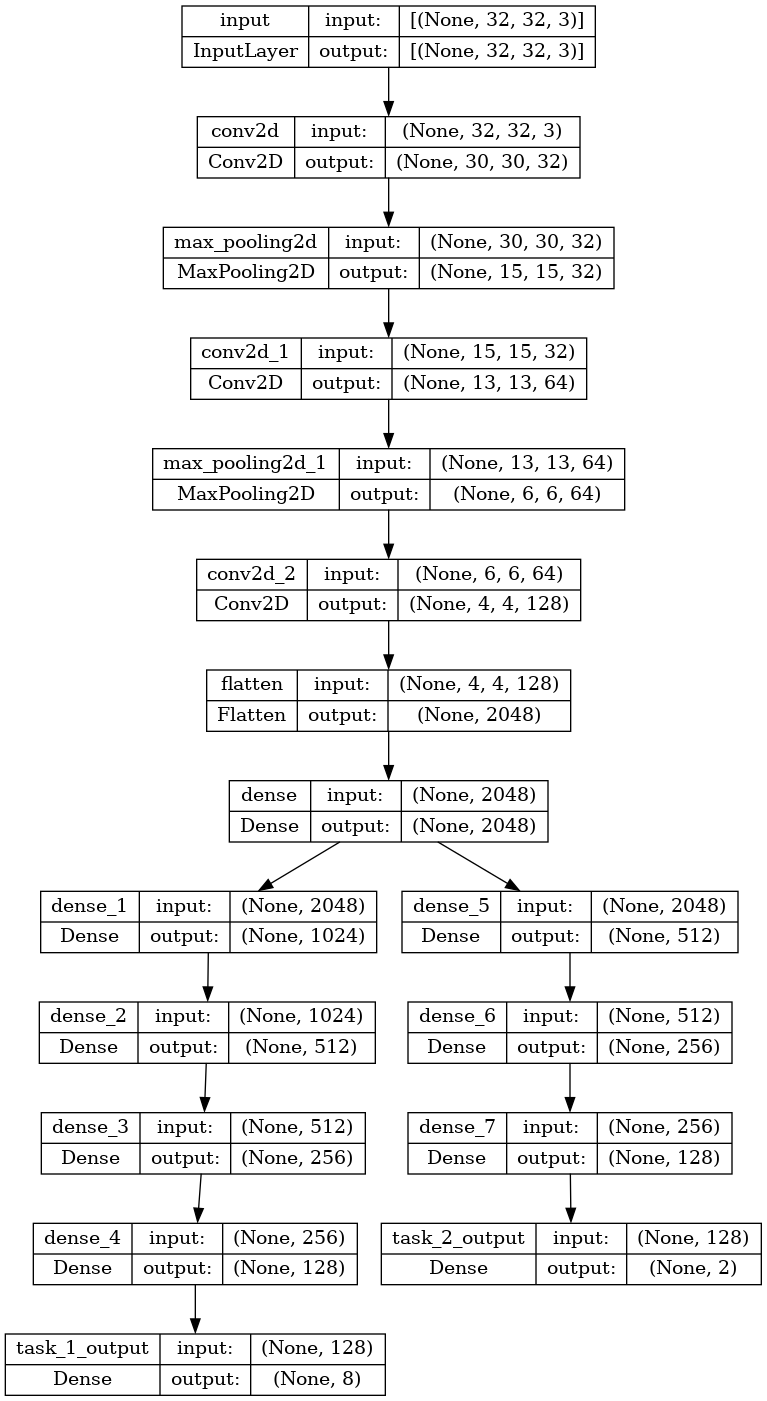

In [20]:
# plot architectures
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 2.2. Case 1: Gamma = 0.5 - The model will receive the loss evenly in both tasks

### Get Model

In [21]:
# get model
model_1 = Model(inputs=inputs, outputs=[task_1_branch, task_2_branch])

### Compile Model

In [22]:
# set gamma
gamma=0.5

In [23]:
# compile model
model_1.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer='adam',
              metrics=['accuracy'])

### Train & Evaluate Model

In [24]:
# train model
history_1 = model_1.fit({'input': new_X_train},
                        {'task_1_output': new_y_train, 'task_2_output': new_y_train_super}, 
                        validation_data=(new_X_test, [new_y_test, new_y_test_super]),
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
313/313 [==============================] - 20s 13ms/step - loss: 0.8723 - task_1_output_loss: 1.4184 - task_2_output_loss: 0.3263 - task_1_output_accuracy: 0.4512 - task_2_output_accuracy: 0.8600 - val_loss: 0.7995 - val_task_1_output_loss: 1.3196 - val_task_2_output_loss: 0.2794 - val_task_1_output_accuracy: 0.4812 - val_task_2_output_accuracy: 0.8865
Epoch 2/20
313/313 [==============================] - 4s 12ms/step - loss: 0.6440 - task_1_output_loss: 1.0637 - task_2_output_loss: 0.2244 - task_1_output_accuracy: 0.6057 - task_2_output_accuracy: 0.9120 - val_loss: 0.6052 - val_task_1_output_loss: 0.9918 - val_task_2_output_loss: 0.2186 - val_task_1_output_accuracy: 0.6313 - val_task_2_output_accuracy: 0.9094
Epoch 3/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5166 - task_1_output_loss: 0.8566 - task_2_output_loss: 0.1765 - task_1_output_accuracy: 0.6876 - task_2_output_accuracy: 0.9316 - val_loss: 0.5849 - val_task_1_output_loss: 0.9485 - val_task_

In [25]:
# train model results
print('Train loss:', history_1.history['loss'][-1])
print('Train task 1 loss:', history_1.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history_1.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history_1.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history_1.history['task_2_output_accuracy'][-1])

Train loss: 0.03654942288994789
Train task 1 loss: 0.05992181971669197
Train task 2 loss: 0.013176994398236275
Train task 1 acc: 0.9804999828338623
Train task 2 acc: 0.9957500100135803


### Evaluate Model

In [26]:
# test model results
evaluation_results = model_1.evaluate(
                        new_X_test, 
                        [new_y_test, new_y_test_super],
                        batch_size=batch_size,
                        verbose=0)

In [27]:
# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 0.9121488928794861
Test task 1 loss: 1.4925446510314941
Test task 2 loss: 0.331753134727478
Test task 1 acc: 0.7232499718666077
Test task 2 acc: 0.9341250061988831


### Plot Results

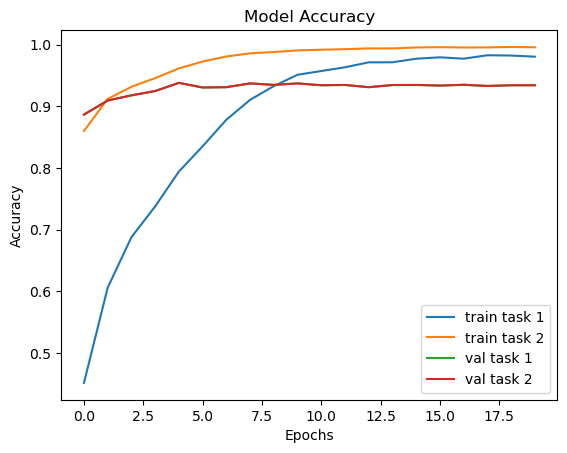

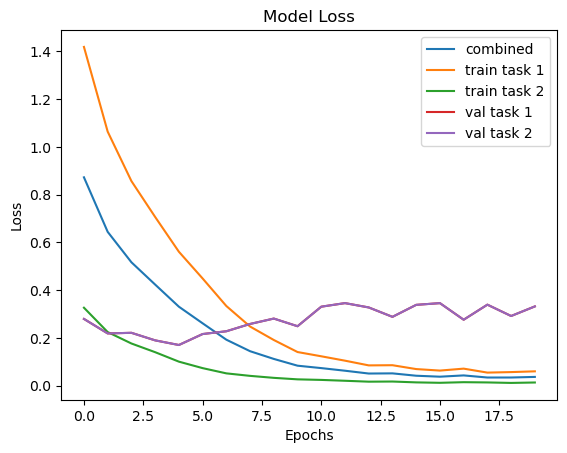

In [28]:
# accuracy plot
plt.plot(history_1.history['task_1_output_accuracy'])
plt.plot(history_1.history['task_2_output_accuracy'])
plt.plot(history_1.history['val_task_2_output_accuracy'])
plt.plot(history_1.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['task_1_output_loss'])
plt.plot(history_1.history['task_2_output_loss'])
plt.plot(history_1.history['val_task_2_output_loss'])
plt.plot(history_1.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

### Test on 5 Images



Image 0 ----------------------------------


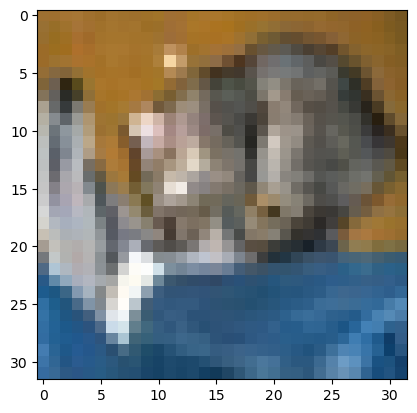

Expected Task 1 label:  cat
Expected Task 2 label:  animal
1/1 [==============================] - 0s 321ms/step
Task 1 prediction:  cat
Task 2 prediction:  vehicle


Image 1 ----------------------------------


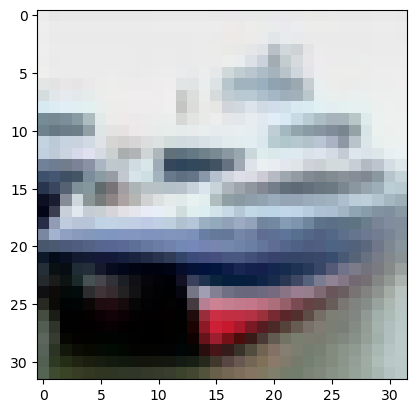

Expected Task 1 label:  ship
Expected Task 2 label:  vehicle
1/1 [==============================] - 0s 46ms/step
Task 1 prediction:  ship
Task 2 prediction:  vehicle


Image 2 ----------------------------------


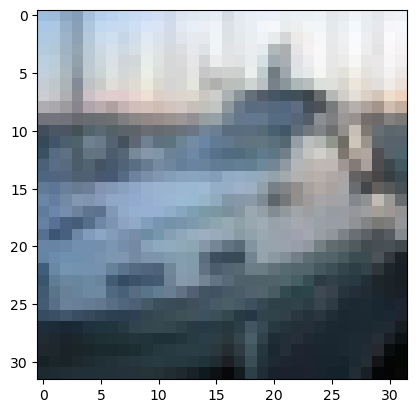

Expected Task 1 label:  ship
Expected Task 2 label:  vehicle
1/1 [==============================] - 0s 38ms/step
Task 1 prediction:  ship
Task 2 prediction:  vehicle


Image 3 ----------------------------------


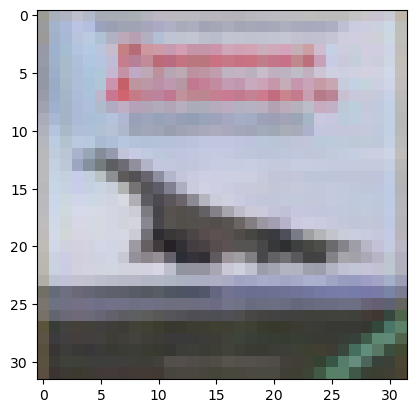

Expected Task 1 label:  airplane
Expected Task 2 label:  vehicle
1/1 [==============================] - 0s 21ms/step
Task 1 prediction:  airplane
Task 2 prediction:  vehicle


Image 4 ----------------------------------


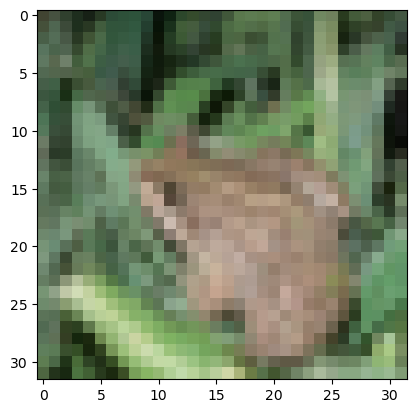

Expected Task 1 label:  frog
Expected Task 2 label:  animal
1/1 [==============================] - 0s 30ms/step
Task 1 prediction:  dog
Task 2 prediction:  animal


In [29]:
for i in range(5):
    print(f"\n\nImage {i} ----------------------------------")
    # get image
    image = X_test[i,:,:,:]
    plt.imshow(image)
    plt.show()

    # get prediction
    print('Expected Task 1 label: ', cifar_mapping[np.argmax(new_y_test[i])])
    print('Expected Task 2 label: ', superclass_mapping[np.argmax(new_y_test_super[i])])

    image = np.expand_dims(image, axis=0)
    
    predicted_cifar, predicted_superclass = model_1.predict(image)
    print('Task 1 prediction: ', cifar_mapping[np.argmax(predicted_cifar)])
    print('Task 2 prediction: ', superclass_mapping[np.argmax(predicted_superclass)])

## 2.3. Case 2: Gamma = 0 - The model will receive the loss of task 2 only


### Get Model

In [30]:
# get model
model_2 = Model(inputs=inputs, outputs=[task_1_branch, task_2_branch])

### Compile Model

In [31]:
# set gamma
gamma=0

In [32]:
# compile model
model_2.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer='adam',
              metrics=['accuracy'])

### Train & Evaluate Model

In [33]:
# train model
history_2 = model_2.fit({'input': new_X_train},
                        {'task_1_output': new_y_train, 'task_2_output': new_y_train_super}, 
                        validation_data=(new_X_test, [new_y_test, new_y_test_super]),
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
313/313 [==============================] - 8s 14ms/step - loss: 0.0258 - task_1_output_loss: 0.1152 - task_2_output_loss: 0.0258 - task_1_output_accuracy: 0.9640 - task_2_output_accuracy: 0.9911 - val_loss: 0.3962 - val_task_1_output_loss: 1.5114 - val_task_2_output_loss: 0.3962 - val_task_1_output_accuracy: 0.7272 - val_task_2_output_accuracy: 0.9327
Epoch 2/20
313/313 [==============================] - 3s 11ms/step - loss: 0.0314 - task_1_output_loss: 0.1798 - task_2_output_loss: 0.0314 - task_1_output_accuracy: 0.9467 - task_2_output_accuracy: 0.9887 - val_loss: 0.2962 - val_task_1_output_loss: 1.7900 - val_task_2_output_loss: 0.2962 - val_task_1_output_accuracy: 0.6883 - val_task_2_output_accuracy: 0.9334
Epoch 3/20
313/313 [==============================] - 3s 11ms/step - loss: 0.0183 - task_1_output_loss: 0.1694 - task_2_output_loss: 0.0183 - task_1_output_accuracy: 0.9484 - task_2_output_accuracy: 0.9938 - val_loss: 0.2762 - val_task_1_output_loss: 1.9140 - val_task_2

In [34]:
# train model results
print('Train loss:', history_2.history['loss'][-1])
print('Train task 1 loss:', history_2.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history_2.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history_2.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history_2.history['task_2_output_accuracy'][-1])

Train loss: 0.01215856708586216
Train task 1 loss: 1.1477776765823364
Train task 2 loss: 0.01215856708586216
Train task 1 acc: 0.8617749810218811
Train task 2 acc: 0.9960749745368958


### Evaluate Model

In [35]:
# test model results
evaluation_results = model_2.evaluate(
                        new_X_test, 
                        [new_y_test, new_y_test_super],
                        batch_size=batch_size,
                        verbose=0)

In [36]:
# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 0.45687854290008545
Test task 1 loss: 4.391406536102295
Test task 2 loss: 0.45687854290008545
Test task 1 acc: 0.6683750152587891
Test task 2 acc: 0.9291250109672546


### Plot Results

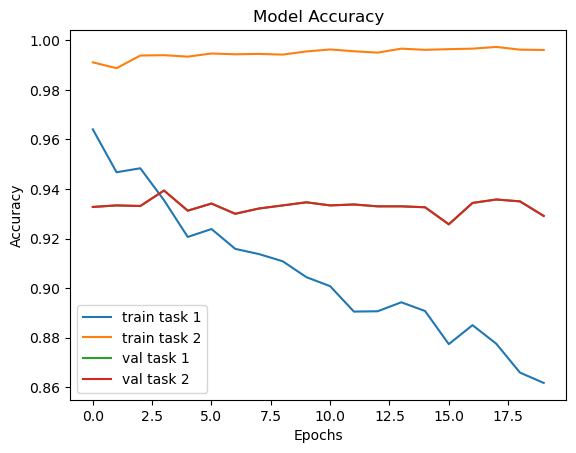

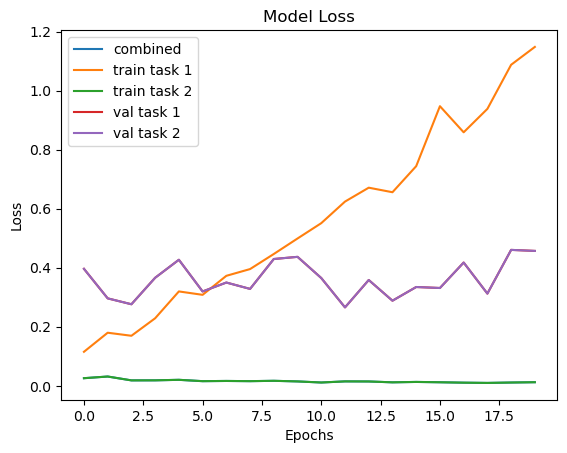

In [37]:
# accuracy plot
plt.plot(history_2.history['task_1_output_accuracy'])
plt.plot(history_2.history['task_2_output_accuracy'])
plt.plot(history_2.history['val_task_2_output_accuracy'])
plt.plot(history_2.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['task_1_output_loss'])
plt.plot(history_2.history['task_2_output_loss'])
plt.plot(history_2.history['val_task_2_output_loss'])
plt.plot(history_2.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

### Test on 5 Images



Image 0 ----------------------------------


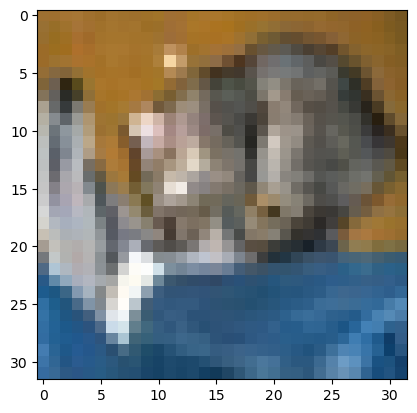

Expected Task 1 label:  cat
Expected Task 2 label:  animal
1/1 [==============================] - 0s 135ms/step
Task 1 prediction:  cat
Task 2 prediction:  animal


Image 1 ----------------------------------


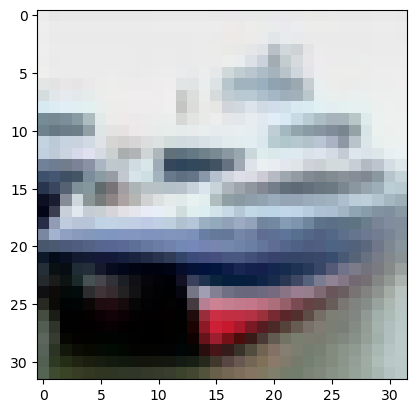

Expected Task 1 label:  ship
Expected Task 2 label:  vehicle
1/1 [==============================] - 0s 22ms/step
Task 1 prediction:  automobile
Task 2 prediction:  vehicle


Image 2 ----------------------------------


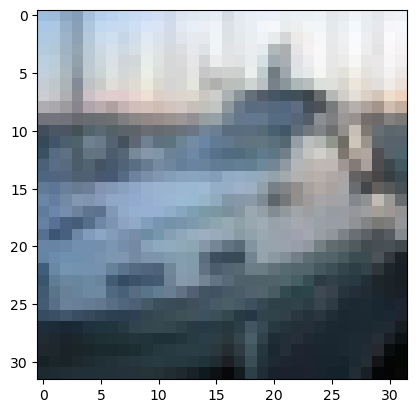

Expected Task 1 label:  ship
Expected Task 2 label:  vehicle
1/1 [==============================] - 0s 22ms/step
Task 1 prediction:  automobile
Task 2 prediction:  vehicle


Image 3 ----------------------------------


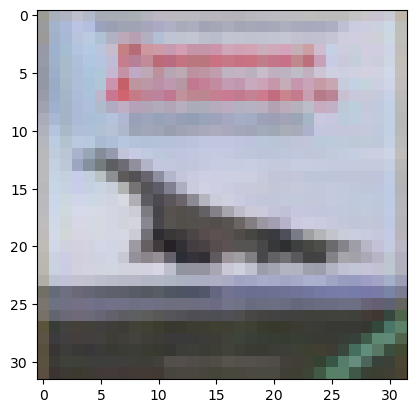

Expected Task 1 label:  airplane
Expected Task 2 label:  vehicle
1/1 [==============================] - 0s 24ms/step
Task 1 prediction:  airplane
Task 2 prediction:  vehicle


Image 4 ----------------------------------


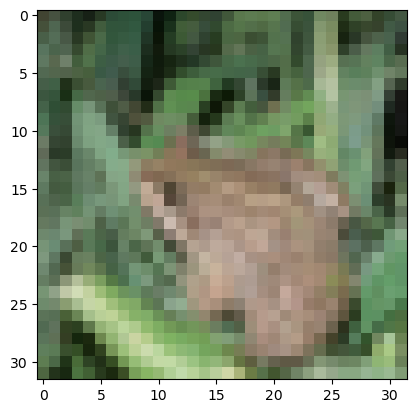

Expected Task 1 label:  frog
Expected Task 2 label:  animal
1/1 [==============================] - 0s 21ms/step
Task 1 prediction:  frog
Task 2 prediction:  animal


In [38]:
for i in range(5):
    print(f"\n\nImage {i} ----------------------------------")
    # get image
    image = X_test[i,:,:,:]
    plt.imshow(image)
    plt.show()

    # get prediction
    print('Expected Task 1 label: ', cifar_mapping[np.argmax(new_y_test[i])])
    print('Expected Task 2 label: ', superclass_mapping[np.argmax(new_y_test_super[i])])

    image = np.expand_dims(image, axis=0)
    
    predicted_cifar, predicted_superclass = model_2.predict(image)
    print('Task 1 prediction: ', cifar_mapping[np.argmax(predicted_cifar)])
    print('Task 2 prediction: ', superclass_mapping[np.argmax(predicted_superclass)])

## 2.4. Case 3: Gamma = 1 - The model will receive the loss from task 1

### Get Model

In [39]:
# get model
model_3 = Model(inputs=inputs, outputs=[task_1_branch, task_2_branch])

### Compile Model

In [40]:
# set gamma
gamma=1

In [41]:
# compile model
model_3.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer='adam',
              metrics=['accuracy'])

### Train & Evaluate Model

In [42]:
# train model
history_3 = model_3.fit({'input': new_X_train},
                        {'task_1_output': new_y_train, 'task_2_output': new_y_train_super}, 
                        validation_data=(new_X_test, [new_y_test, new_y_test_super]),
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
313/313 [==============================] - 8s 14ms/step - loss: 0.1976 - task_1_output_loss: 0.1976 - task_2_output_loss: 0.0037 - task_1_output_accuracy: 0.9373 - task_2_output_accuracy: 0.9991 - val_loss: 1.4870 - val_task_1_output_loss: 1.4870 - val_task_2_output_loss: 0.3465 - val_task_1_output_accuracy: 0.7244 - val_task_2_output_accuracy: 0.9334
Epoch 2/20
313/313 [==============================] - 3s 11ms/step - loss: 0.0688 - task_1_output_loss: 0.0688 - task_2_output_loss: 0.0028 - task_1_output_accuracy: 0.9782 - task_2_output_accuracy: 0.9994 - val_loss: 1.5368 - val_task_1_output_loss: 1.5368 - val_task_2_output_loss: 0.3503 - val_task_1_output_accuracy: 0.7153 - val_task_2_output_accuracy: 0.9324
Epoch 3/20
313/313 [==============================] - 3s 11ms/step - loss: 0.0590 - task_1_output_loss: 0.0590 - task_2_output_loss: 0.0019 - task_1_output_accuracy: 0.9822 - task_2_output_accuracy: 0.9995 - val_loss: 1.5289 - val_task_1_output_loss: 1.5289 - val_task_2

In [43]:
# train model results
print('Train loss:', history_3.history['loss'][-1])
print('Train task 1 loss:', history_3.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history_3.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history_3.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history_3.history['task_2_output_accuracy'][-1])

Train loss: 0.04811424762010574
Train task 1 loss: 0.04811424762010574
Train task 2 loss: 0.009390088729560375
Train task 1 acc: 0.9856500029563904
Train task 2 acc: 0.9967250227928162


### Evaluate Model

In [44]:
# test model results
evaluation_results = model_3.evaluate(
                        new_X_test, 
                        [new_y_test, new_y_test_super],
                        batch_size=batch_size,
                        verbose=0)

In [45]:
# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 1.4611806869506836
Test task 1 loss: 1.4611806869506836
Test task 2 loss: 0.4771712124347687
Test task 1 acc: 0.7210000157356262
Test task 2 acc: 0.9318749904632568


### Plot Results

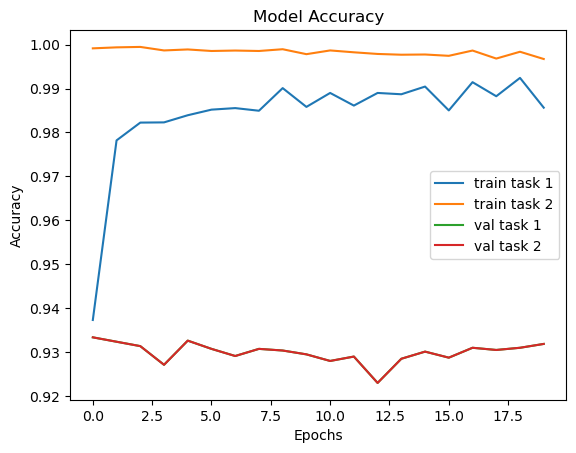

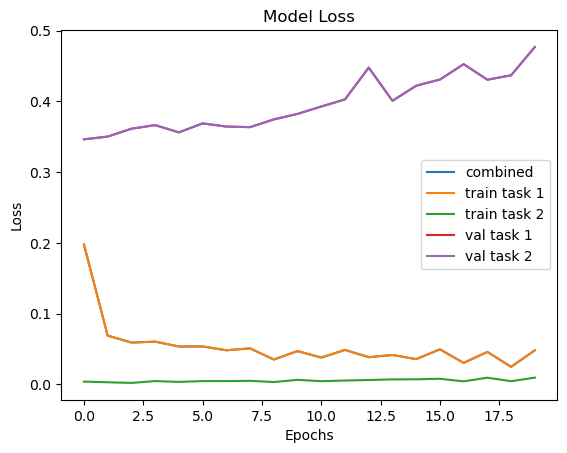

In [46]:
# accuracy plot
plt.plot(history_3.history['task_1_output_accuracy'])
plt.plot(history_3.history['task_2_output_accuracy'])
plt.plot(history_3.history['val_task_2_output_accuracy'])
plt.plot(history_3.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['task_1_output_loss'])
plt.plot(history_3.history['task_2_output_loss'])
plt.plot(history_3.history['val_task_2_output_loss'])
plt.plot(history_3.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

### Test on 5 Images



Image 0 ----------------------------------


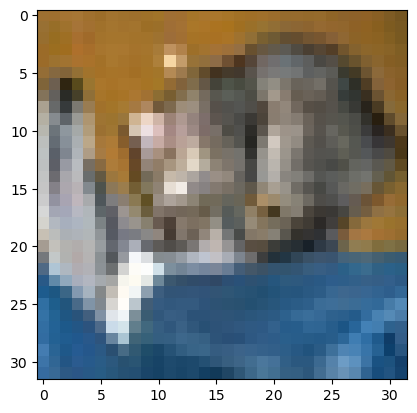

Expected Task 1 label:  cat
Expected Task 2 label:  animal
1/1 [==============================] - 0s 129ms/step
Task 1 prediction:  airplane
Task 2 prediction:  vehicle


Image 1 ----------------------------------


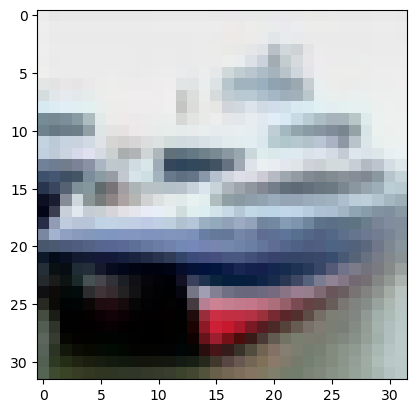

Expected Task 1 label:  ship
Expected Task 2 label:  vehicle
1/1 [==============================] - 0s 22ms/step
Task 1 prediction:  airplane
Task 2 prediction:  vehicle


Image 2 ----------------------------------


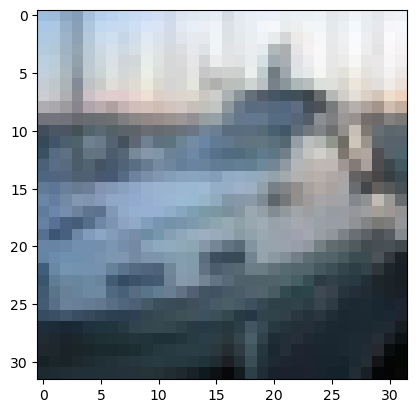

Expected Task 1 label:  ship
Expected Task 2 label:  vehicle
1/1 [==============================] - 0s 28ms/step
Task 1 prediction:  airplane
Task 2 prediction:  vehicle


Image 3 ----------------------------------


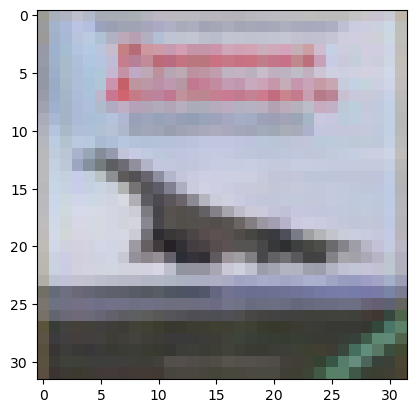

Expected Task 1 label:  airplane
Expected Task 2 label:  vehicle
1/1 [==============================] - 0s 21ms/step
Task 1 prediction:  airplane
Task 2 prediction:  vehicle


Image 4 ----------------------------------


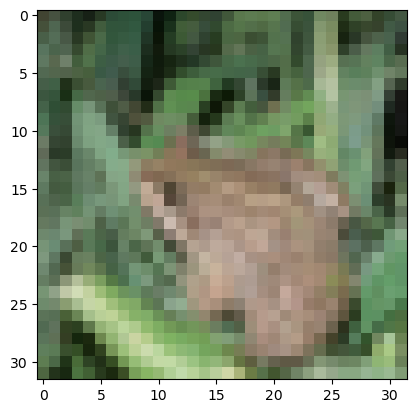

Expected Task 1 label:  frog
Expected Task 2 label:  animal
1/1 [==============================] - 0s 20ms/step
Task 1 prediction:  frog
Task 2 prediction:  animal


In [47]:
for i in range(5):
    print(f"\n\nImage {i} ----------------------------------")
    # get image
    image = X_test[i,:,:,:]
    plt.imshow(image)
    plt.show()

    # get prediction
    print('Expected Task 1 label: ', cifar_mapping[np.argmax(new_y_test[i])])
    print('Expected Task 2 label: ', superclass_mapping[np.argmax(new_y_test_super[i])])

    image = np.expand_dims(image, axis=0)
    
    predicted_cifar, predicted_superclass = model_3.predict(image)
    print('Task 1 prediction: ', cifar_mapping[np.argmax(predicted_cifar)])
    print('Task 2 prediction: ', superclass_mapping[np.argmax(predicted_superclass)])